# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['1960520', '1953567', '2008580', '1979531']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from files.treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

In this part we choose our research question as well as formulate several hypotheses to eventually pick one that works.

**Research question** - How different weather factor correlate with O3 and NOx?

### Three formulated hypothesis: 

#1 The concentration of air pollutants, specifically NOx, O3, is correlated with a combination of industrial emissions, meteorological conditions, and natural phenomena.(Motivation - we would like to find out if the if and how industrial areas correlate with the air pollutants.) 

#2 Sunshine saturation correlates to concentrations of both NOx and O3 respectively. (Motivation - getting to know if sunshine might take a role in concentration of these compounds.)

#3 Thunder correlates to concentration of of O3 while rainfal does not. (Motivation - finding out the difference between the correlations of two different weather conditions and compound concentration.)


These hypothese have already been sorted by us from the most prefered to least, so in further steps we will use the hypothesis #1

## Part 1b: Hypothesis refinement

## Key words

First we refine underlined key words to be clear and specific with valid arguments for choices made. Here for the underlinig we use bold text as Jupyter doesn't have a way to underline text.

**The original hypothesis**: “ The concentration of air pollutants, specifically NOx, O3, is correlated to a combination of **industrial emissions**, **meteorological conditions**, and **natural phenomena** ”


We have refined it as follows:
- industrial emissions
    - which industrial areas specifically? Rotterdam – because O3 is one of the main pollutants in this area and the US AQI is 48, moreover we have data from measuring stations in that area
    - Specify which type emissions: point and mobile   
 
- meteorological conditions
   - sunshine saturation (to test if it actually has the same effect on both compounds)
   - and temperature (to explore if it is correlated to sunshine saturation, and if so it would also have the same effect on both compounds)
 - natural phenomena
   - Explore the correlation between 03 and BOTH thunder and rainfall (to have a comparison variable) 
        
**The refined hypothesis thus becomes** “The concentration of air pollutants, specifically NOx, O3, is correlated to a combination of emissions coming from industrial areas around Rotterdam , meteorological conditions such as sunshine saturation and temperature, and how it is affected by thunder and rainfall”


## Confounding variables

Before the testing begins we also need to discuss some possible confounding variables that may occcur in our test.

 1. Geographical features - The presense of hills, bodies of water and other factors can affect the data for specific weather stations.
 2. Other pollutants - the presence of other compounds in the air could have an impact on the concentration of NOx and O3. Some pollutants could react with each other under certain conditions causing different levels of concentration.
 3. Human activity - This includes factors as varying industrial activity, for example, with public holidays, COVID lockdown etc.
 4. Seasons - during different seasons there are different weather and human activity patterns. For instance, sunshine saturation and temperature varies between summer and winter, but also during winter there is a spike in usage of fossil fuels.
 

## Choosing air quality stations

**Considerations while choosing air quality and weather stations**:

Air Quality stations in Rotterdam are affected by wind, causing surrounding areas, which are relatively less industrial, to have higher concentrations too.

Weather stations in and around Rotterdam need to be chosen with consideration of the types of emissions there. Wind direction and vectors can be observed by comparing concentrations in different directions but at similar distances. Wind speeds can be correlated with the distance to Rotterdam.

Compounds such as O3 and NOx, along with sunshine and temperature, need to be monitored. Comparing sunshine and temperature can help look for correlations and determine if they have the same effect on these compounds.

In addition to O3 and NOx, thunder and rainfall also need to be taken into account.

**Weather Stations** (from the Royal Netherlands Meteorological Institute (KNMI))
 - STN 344 – Rotterdam 
 - STN 343 – Rotterdam Geulhaven, the station located at the port which may give interesting results
 
**Air Quality Stations** (in order of distance from Rotterdam)
 - NL01493 - Rotterdam Noord -Statenweg (≈ 4.0 km)
 - NL01494 - Schiedam-Alphons Arienstraat (≈ 5.5 𝑘𝑚)
 - NL10418 - Rotterdam-Schiedamsevest(≈ 5.8 𝑘𝑚)
 - NL10449 - Vlaardingen-Riouwlaan (station closest to the port weather station (≈ 2 𝑘𝑚 ), ≈9.6 𝑘𝑚)
 
**Farther air quality stations**
 - NL10437 - Westmaas-Groeneweg (direction south, ≈ 19.5 𝑘𝑚)
 - NL01495 - Maassluis-Kwartellaan (direction west, ≈ 15.4 𝑘𝑚)
 - NL10442 - Dordrecht-Bamendaweg (direction southeast, ≈ 25.4 𝑘𝑚)
 
Here, we attempted to select stations in different cardinal directions to possibly link wind 
vector data to changing concentrations.


The approximate distance of the air quality stations to the main Rotterdam weather station 
have been included so that they are taken into consideration while analyzing results. For 
example, the ‘Farther stations’ should only be compared to each other with attention to their 
location on the map. This will help to minimize possible outliers and unexpected results while 
still allowing us to explore the impact of the chosen weather factors with more detail.

## Part 2: Queries and data cleaning

This part is worked on by Sinjini and Maks

In [27]:
# Assigning variables to chosen weather stations and compounds

aq_station_code_0 = 'NL01493'
aq_station_code_1 = 'NL01494'
aq_station_code_2 = 'NL10418'
aq_station_code_3 = 'NL10449'
aq_station_code_4 = 'NL10437'
aq_station_code_5 = 'NL01495'
aq_station_code_6 = 'NL10442'

compound1 = 'o_3'
compound2 = 'no_x'

aq_station_codes = [aq_station_code_0, aq_station_code_1, aq_station_code_2, aq_station_code_3,
                      aq_station_code_4, aq_station_code_5, aq_station_code_6]

compound_list = [compound1, compound2]

In [8]:
# Queries to verify the closest weather station to the air quality stations

# Creating path to the database
db_path = 'GA1_files/aqw.db'

# Connecting to database
cnx = sqlite3.connect(db_path)


for aq_station_code in aq_station_codes:
    QUERY_WEATHER_STATION = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code}' 
    GROUP BY aq_station_code
    """

    closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION, cnx).squeeze()

# Extract weather code from the SQL result
    weather_station_code = int(closest_weather_info['weather_station_code'])

# Extract weather station distance from the SQL result
    aq_weather_distance = closest_weather_info['distance']

    print(f'The closest weather station to your air quality station, {aq_station_code}, is station '
      f'{weather_station_code}, with a distance of {aq_weather_distance} kilometers.')

 

The closest weather station to your air quality station, NL01493, is station 344, with a distance of 4.0 kilometers.
The closest weather station to your air quality station, NL01494, is station 344, with a distance of 5.5 kilometers.
The closest weather station to your air quality station, NL10418, is station 344, with a distance of 5.8 kilometers.
The closest weather station to your air quality station, NL10449, is station 344, with a distance of 9.6 kilometers.
The closest weather station to your air quality station, NL10437, is station 344, with a distance of 19.5 kilometers.
The closest weather station to your air quality station, NL01495, is station 344, with a distance of 15.4 kilometers.
The closest weather station to your air quality station, NL10442, is station 344, with a distance of 25.4 kilometers.


The query above was used to find the closest weather station to each of the selected air quality stations. As was expected and is ideal, they are all closest to the same station, STN 344 in Rotterdam. The estimated distances between stations were changed to more precise ones outputted by the query. This will help us analyse the results in a more informed manner as distance to the weather stations should influence correlations as well and we may have to question their validity. 

In [19]:
#Extracting air quality data from chosen stations

# Getting o_3 and no_2 info of the air quality stations and adding the dataframes to a list to be accessed individually

df_aq_code = []

for station_code in aq_station_codes:
    QUERY_AQ = f"""
        SELECT datetime, {', '.join((compound1, compound2))} 
        FROM air_quality_data 
        WHERE station_code='{station_code}'
        """
    
    
    df_aq_code.append(pd.read_sql_query(QUERY_AQ, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime']))


df_aq_code[6]

,o_3,no_x
datetime,,
2012-01-01 01:00:00+01:00,66.86,34.96
2012-01-01 02:00:00+01:00,50.39,13.40
2012-01-01 03:00:00+01:00,51.44,9.22
2012-01-01 04:00:00+01:00,51.14,9.38
2012-01-01 05:00:00+01:00,53.70,7.51
...,...,...
2021-12-31 19:00:00+01:00,41.96,11.12
2021-12-31 20:00:00+01:00,46.89,9.33
2021-12-31 21:00:00+01:00,45.35,13.17


In [20]:
df_aq_code[0]

,o_3,no_x
datetime,,
2012-01-01 01:00:00+01:00,28.0,56.180
2012-01-01 02:00:00+01:00,33.1,40.780
2012-01-01 03:00:00+01:00,38.3,35.740
2012-01-01 04:00:00+01:00,40.4,35.210
2012-01-01 05:00:00+01:00,40.7,32.770
...,...,...
2021-12-31 19:00:00+01:00,26.2,36.440
2021-12-31 20:00:00+01:00,23.8,38.753
2021-12-31 21:00:00+01:00,23.9,38.680


In [24]:
#Assinging a variable to the weather factors that wish to explore for extracting weather data

WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'temperature', 
                  'sunshine_duration', 'rainfall', 'thunder']

QUERY_WEATHER = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code}
"""

# Get weather data of the closest weather station
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])



In [41]:

df_data_list = []

for i, df_aq_code_i in enumerate(df_aq_code):
    
    selected_columns = ['datetime'] + compound_list
    
    joined_df = df_aq_code_i[selected_columns].join(df_weather, how='outer', rsuffix=f'_{i}')
    
    df_data_list.append(joined_df)

TypeError: string indices must be integers

In [32]:
df_data['year'] = df_data.index.year
df_data['month'] = df_data.index.month
df_data['day_of_year'] = df_data.index.dayofyear
df_data['week'] = df_data['day_of_year'] // 7 + 1
df_data['hour'] = df_data.index.hour

In [33]:
df_data.head()

,o_3,no_x,wind_direction,wind_speed,temperature,sunshine_duration,rainfall,thunder,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,,
2012-01-01 00:00:00+01:00,NaN,NaN,230,9.0,10.7,0.0,1,0,2012,1,1,1,0
2012-01-01 01:00:00+01:00,66.86,34.96,240,8.0,10.9,0.0,1,0,2012,1,1,1,1
2012-01-01 02:00:00+01:00,50.39,13.40,230,8.0,11.1,0.0,1,0,2012,1,1,1,2
2012-01-01 03:00:00+01:00,51.44,9.22,230,10.0,11.4,0.0,1,0,2012,1,1,1,3
2012-01-01 04:00:00+01:00,51.14,9.38,230,10.0,11.4,0.0,1,0,2012,1,1,1,4


End of the part done by Sinjini and Maks

<Axes: >

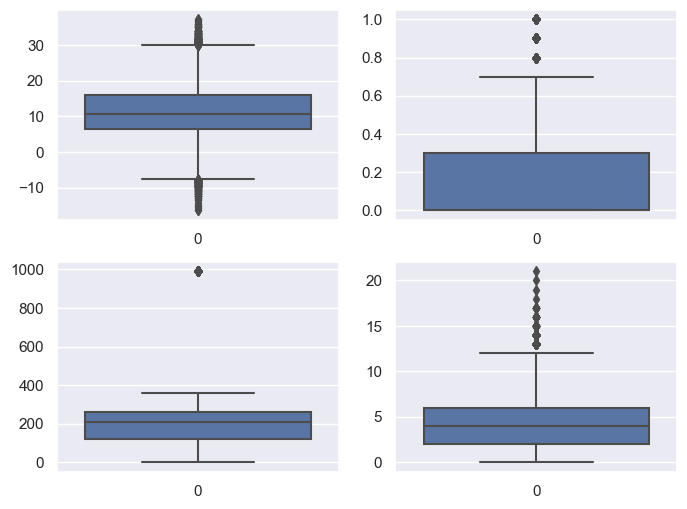

In [45]:
#Plotting weather factors except rainfall and thunder to make sure the data is correct/reasonable

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

sns.boxplot(df_data['temperature'], ax=ax[0][0])
sns.boxplot(df_data['sunshine_duration'], ax=ax[0][1])
sns.boxplot(df_data['wind_direction'], ax=ax[1][0])
sns.boxplot(df_data['wind_speed'], ax=ax[1][1])


## Part 3. Hypothesis testing and interpretation

In [ ]:
# Use this cell as you like, and add more cells as needed.

## Part 4. Polishing and pitching results

In [ ]:
# This section is only for generating figures if you need it. You may leave it empty.


In [ ]:
# Close database connection
cnx.close()

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)

#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)

#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

### (Optional) What did you like?

Assign a string to `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [ ]:
# List all defined names
%whos

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology